In [2]:
from models.deepclean import DeepCleanAE
from signal_gen.generate_signal import build_empty_signal, gauss_sig
from signal_gen.colored_noise import add_noise_to_signal
import matplotlib.pyplot as plt
from models.base_dense import BaselineDense

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# generate dataset

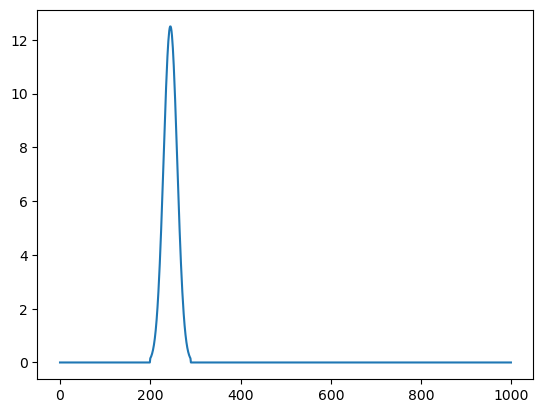

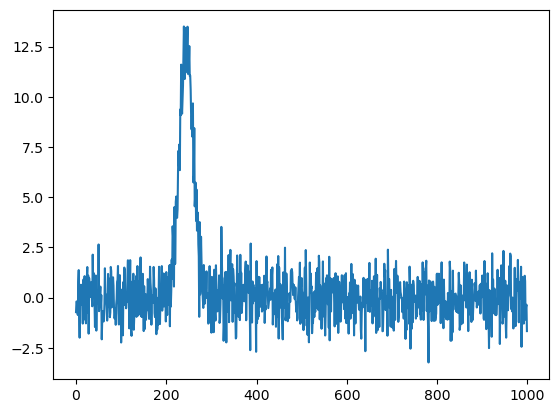

In [5]:
n = 1000
sr = 10000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3
c_freq = 100
m_index = 1

# Build the signal
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)
plt.show()
x_noised, noise = add_noise_to_signal(x, "white", sr=sr)
plt.plot(x_noised)
plt.show()

In [8]:
# dataset to learn the noise
dataset_size = 10_000
X = []  # unipolar gaussian + white noise
Y = []  # white noise
for _ in range(dataset_size):
    x, t = build_empty_signal(n, sr)
    x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    x_noised, noise = add_noise_to_signal(x, "white", sr=sr)
    X.append(x_noised)
    Y.append(noise)

In [ ]:
# dataset to learn the signal
dataset_size = 10_000
X = []  # unipolar gaussian + white noise
Y = []  # white noise
for _ in range(dataset_size):
    x, t = build_empty_signal(n, sr)
    x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    x_noised, noise = add_noise_to_signal(x, "white", sr=sr)
    X.append(x_noised)
    Y.append(x)

In [9]:
X = torch.tensor(X).to(torch.float32)
Y = torch.tensor(Y).to(torch.float32)
print(X.shape)
print(Y.shape)

torch.Size([10000, 1000])
torch.Size([10000, 1000])


# Training

In [11]:
# dataset generation
batch_size = 512
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
baseline_dense_config = {
    "input_size": n,
    "lin1_size": 512,
    "lin2_size": 128,
    "lin3_size": 512,
    "output_size": n
}   
model = BaselineDense(baseline_dense_config)

# Loss function and optimizer
criterion = nn.MSELoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
train_loss = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        x1 = outputs
        x2 = inputs - outputs
        x3 = inputs
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.10f}')
    train_loss.append(running_loss/len(train_loader))

Epoch [1/1000], Loss: 1.0389542401
Epoch [2/1000], Loss: 1.0039971888
Epoch [3/1000], Loss: 0.9997253001
Epoch [4/1000], Loss: 0.9934683204
Epoch [5/1000], Loss: 0.9838844717
Epoch [6/1000], Loss: 0.9720546007
Epoch [7/1000], Loss: 0.9590337038
Epoch [8/1000], Loss: 0.9464890063
Epoch [9/1000], Loss: 0.9335375100
Epoch [10/1000], Loss: 0.9212838501
Epoch [11/1000], Loss: 0.9097239673
Epoch [12/1000], Loss: 0.8999040872
Epoch [13/1000], Loss: 0.8912541866
Epoch [14/1000], Loss: 0.8839527071
Epoch [15/1000], Loss: 0.8779175133
Epoch [16/1000], Loss: 0.8721470386
Epoch [17/1000], Loss: 0.8674929887
Epoch [18/1000], Loss: 0.8629646122
Epoch [19/1000], Loss: 0.8587113708
Epoch [20/1000], Loss: 0.8560321391
Epoch [21/1000], Loss: 0.8514577210
Epoch [22/1000], Loss: 0.8485248476
Epoch [23/1000], Loss: 0.8454614818
Epoch [24/1000], Loss: 0.8422674477
Epoch [25/1000], Loss: 0.8402924210
Epoch [26/1000], Loss: 0.8377125472
Epoch [27/1000], Loss: 0.8352760404
Epoch [28/1000], Loss: 0.8326160222
E

In [ ]:
plt.plot(train_loss)
plt.title("mlp to learn noise, training loss")
plt.xlabel("Epoch")

# Analysis

In [11]:
in_channels = 1
model = DeepCleanAE(in_channels)
model.load_state_dict(torch.load("deepclean_model.pth"))
model = model.eval()

In [35]:
batch_size = 16
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.MSELoss()  # Suitable for classification tasks

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        
        x1 = outputs
        x2 = inputs.squeeze(dim=1) - outputs
        x3 = inputs.squeeze(dim=1)
        
        # Compute loss
        loss = criterion(outputs, labels)

        print("loss: ", loss.detach().item())
        
        break
        

loss:  0.21906450390815735


In [40]:
model.encodings["input_conv"]

(16, 1, 10000)